In [1]:
from scipy.ndimage.filters import gaussian_filter1d
import pandas as pd
import seaborn as sn
import sys
sys.path.insert(0, '../build')

import pyabcranger
import sys
import elfi
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
import math
import numpy as np


def MAq(t, n_obs=10000, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    s = t.shape[1]
    assert t.shape[0] == batch_size
    random_state = random_state or np.random
    w = random_state.randn(batch_size, n_obs+s)  # i.i.d. sequence ~ N(0,1)
    x = w[:, s:]
    for p in range(s):
        x = x + np.repeat(np.reshape(t[:, p], (batch_size, 1)),
                          n_obs, axis=1)*w[:, (s-p-1):(-p-1)]
    return x

def generate_maq_priors(q, tq , batch_size=1, random_state=None):
    assert tq.shape[0] == batch_size
    d = q // 2
    if (q % 2) == 0:
        d = d - 1
    random_state = random_state or np.random
    nc = random_state.randint(q, size=batch_size)
    nd = random_state.randint(d, size=batch_size)
    #r = np.random.uniform(min, max, (batch_size, 1))
    genr = np.exp(random_state.dirichlet(
        np.ones(q), batch_size)*np.log(np.abs(1/tq[:,np.newaxis])))
    # genr = genr * randSign(q,(r <= 0),batch_size)
    genr[:, -1] = -genr[:, -1]
    alphas = np.zeros((batch_size, q))
    for i in range(batch_size):
        gen = random_state.uniform(0, math.pi, nd[i])
        d2 = (q - (2*nd[i])) // 2
        if (q % 2) == 0:
            d2 = d2 - 1
        nq = random_state.randint(d2)
        alphas[i, :nd[i]] = gen
        alphas[i, nd[i]:(2*nd[i])] = -gen
        alphas[i, -(2*nq+1):] = -1
    roots = np.zeros((batch_size, q), dtype=complex)
    roots.real = np.cos(alphas)
    roots.imag = np.sin(alphas)
    if (q % 2) != 0:
        roots[:, nc] = -roots[:, nc]
    roots = roots / genr
    assert np.min(np.abs(roots)) > 1, str(roots)  # Prior constraint checking
    poly = np.apply_along_axis(
        np.polynomial.polynomial.polyfromroots, 1, roots).real[:, 1:]
    return poly * np.reshape(tq, (batch_size, 1))

Ncovmult=4

def pautocorr(x, to=1):
    C = np.zeros((x.shape[0], to*Ncovmult))
    for i in range(x.shape[0]):
        C[i, 0::Ncovmult] = acf(x[i][1:], True, nlags=to, fft=True)[1:]
        res = pacf(x[i][1:], nlags=to, method='ols', alpha=0.05)
        C[i, 1::Ncovmult] = res[0][1:]
        C[i, 2::Ncovmult] = res[1][1:, 0]
        C[i, 3::Ncovmult] = res[1][1:, 1]
    return C

class ClassPrior(elfi.Distribution):
    def rvs(n, size=1, random_state=None):
        random_state = random_state or np.random
        return random_state.choice(n,size,p=np.arange(n,0,-1)/(n*(n+1)/2))
        
class GlobalPrior(elfi.Distribution):
    def rvs(qp, tq, qpriors, size=1, random_state=None):
        class_count = np.zeros(qpriors.shape[0], dtype='int')
        res = np.zeros((size[0], maxt))
        for q in range(qpriors.shape[0]):
            qr = qpriors[q]
            class_count[q] = np.sum(qp == q)
            if (class_count[q] > 0):
                res[qp == q, :qr] = generate_maq_priors(
                    qr, tq[qp == q], class_count[q],random_state)
        return res
    
def listvar(prefix, s):
    return [prefix+str(i) for i in range(1, s+1)]

def listvarautocorr(s):
    arr = []
    for i in range(1, s//Ncovmult+1):
        arr.append("acf"+str(i))
        arr.append("pacf"+str(i))
        arr.append("pacfq1_"+str(i))
        arr.append("pacfq2_"+str(i))
    return arr

In [2]:
minprior = 1
maxprior = 2
ntree = 500
Ny = 200  # Length of the serie
Ncov = 20  # Maximum of autocorrelation lag
q = 10  # Our chosen q for the observed data
nref = 2000  # Number of expected simulated data from ABC
batchsize = 100

#qpriors = np.array([6,7,8,9,10,11,12,13,14,15,16])
qpriors = np.arange(6,17,dtype=np.int)
nclasses = qpriors.shape[0]
maxt = np.max(qpriors)

In [3]:
tq = elfi.Prior('uniform',1,1)
qp = elfi.Prior(ClassPrior, nclasses)
t  = elfi.Prior(GlobalPrior, qp, tq, qpriors)

Y = elfi.Simulator(MAq, t)
S = elfi.Summary(pautocorr, Y, Ncov)
d = elfi.Distance('euclidean', S)

elfi.set_client('multiprocessing')
rej = elfi.Rejection(d, batch_size=batchsize, output_names=['S'])

In [4]:
from tqdm.notebook import tqdm, trange
predicted = []
postproba = []


with trange(100) as tr:
    for k in tr:
        # Generation of the observed data
        modsimple = generate_maq_priors(q, np.random.uniform(low=1.0,high=2.0,size=(1)))
        y_obs = MAq(modsimple, Ny)

        Y.become(elfi.Simulator(MAq,t,observed=y_obs))
        result = rej.sample(nref, quantile=1.0,bar=False)

        rf = pyabcranger.reftable(
            nref,
            [np.sum(result.samples['qp'] == i) for i in range(nclasses)],
            qpriors,
            listvar('t', maxt),
            listvarautocorr(result.outputs['S'].shape[1]),
            result.outputs['S'],
            result.samples['t'],
            result.samples['qp']+1
        )

        postres = pyabcranger.modelchoice(
            rf, S.observed[0], "--ntree "+str(ntree), True)

        tr.set_postfix(model=qpriors[postres.predicted_model])
        predicted.append(qpriors[postres.predicted_model])
        postproba.append(postres.post_proba)

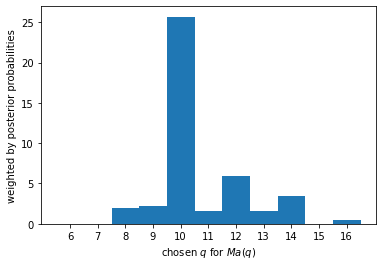

In [5]:
plt.figure()
plt.hist(predicted,np.arange(6,18),weights=postproba,align='left')
plt.xticks(np.arange(6,17))
plt.xlabel("chosen $q$ for $Ma(q)$")
plt.ylabel("weighted by posterior probabilities")
plt.savefig("modelchoice-loop.svg",format="svg");